In [14]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [15]:
fracs_count = 3  # количество трещин
K_c = 1e6  # Па*м^(1/2) трещиностойкость

In [16]:
# параметры задачи в символьном виде

Q_0, p_0 = symbols('Q0 p0', real=True)  # суммарный расход на забое и забойное давление

Q = np.array(symbols(f'Q1:{fracs_count+1}', real=True))  # расходы на каждой из трещин
x_f = np.array(symbols(f'x_f1:{fracs_count+1}', real=True))  # полудлина каждой из трещин
E = np.array(symbols(f'E1:{fracs_count+1}', real=True))  # модуль плоской деформации каждой из трещин
h = np.array(symbols(f'h1:{fracs_count+1}', real=True))  # мощность продуктивной зоны каждой из трещин
K, n, phi = symbols('K n phi', real=True)  # реологические параметры жидкости и геометрический параметр трещины
k_e = symbols('k_e', real=True)  # проницаемость пласта
p_e = symbols('p_e', real=True)  # пластовое давление
phi_e = symbols('phi_e', real=True)  # пористость пласта
c_t = symbols('c_t', real=True)  # общая сжимаемость
t = symbols('t', real=True)  # время
p_frac_net = np.array(symbols(f'p_frac_net1:{fracs_count+1}', real=True))  # чистые давления на каждой из трещин

n_p = np.array(symbols(f'n_p1:{fracs_count+1}', real=True))  # количество перфораций на каждой из трещин
d_p = np.array(symbols(f'd_p1:{fracs_count+1}', real=True))  # диаметр перфораций на каждой из трещин
C_d = np.array(symbols(f'C_d1:{fracs_count+1}', real=True))  # коэффициент эррозии на каждой из трещин
rho_s = symbols('rho_s', real=True)  # средняя плотность смеси

R = np.array(symbols(f'R1:{fracs_count+1}', real=True))  # радиус участков трубы к каждой из трещин
L = np.array(symbols(f'L1:{fracs_count+1}', real=True))  # длина участков трубы, ведущих к каждой из трещин

u_m = np.array(symbols(f'u_m1:{fracs_count+1}', real=True))  # средняя скорость на рассматриваемом участке к каждой из трещин
sigma_min = symbols(f'sigma_min1:{fracs_count+1}')  # давление закрытия для каждой из трещин

In [17]:
# чистое давление в трещинах
def p_net():
    V = h * (2 * x_f) * K_c * (S.Pi*h)**(1/2) / E
    a = (((n + 3) * (2 * n + 1)**n * K * E**(2*n+2)) / \
         (S.Pi * 2**(2 * n) * n**n * phi**n * h**(3 * n + 3))) ** (1 / (2 * n + 3))
    p_net = a * Q**(n/(2*n+3)) * V**(1/(2*n+3))  # давление на каждой из трещин
    return p_net

# падение давления на перфорациях
def delta_p_perf():
    # падение давления на перфорациях на каждой из трещин
    delta_p_perf = 8 * rho_s / (S.Pi**2 * C_d**2 * n_p**2 * d_p**4) * Q * abs(Q)
    return delta_p_perf

# падение давления на трение в трубе
def delta_p_fric():
    for i, _ in enumerate(u_m):
        u_m[i] = (Q_0 - sum([Q[j] for j in range(i)])) / (S.Pi * R[i]**2)
    delta_p_fric = 8 * (K / R) * (u_m / R) * L # падение давления на трение в трубе для каждой из трещин
    return delta_p_fric

In [18]:
def kirchhoff_solver(parameter_values):
    all_eqns = np.array([])  # массив со всеми уравнениями законов Кирхгофа
    
    # добавляем левую часть уравнений второго закона Кирхгофа в массив all_eqns
    for i in range(fracs_count):
        all_eqns = np.append(all_eqns, p_0 - sigma_min[i] - p_net()[i] - delta_p_perf()[i] - sum([delta_p_fric()[j] for j in range(i+1)]))

    # добавляем левую часть уравнения первого закона Кирхгофа в массив all_eqns
    all_eqns = np.append(all_eqns, Q_0 - sum(Q))
    
    # матрица Якоби
    J = np.zeros(shape=(fracs_count+1, fracs_count+1), dtype=object)
    for i, _ in enumerate(all_eqns):
        for j, _ in enumerate(Q):
            J[i, j] = diff(all_eqns[i], Q[j])
        J[i, -1] = diff(all_eqns[i], p_0)
    J_sym = Matrix(J)

    # начальные приближения числовых значений неизвестных параметров задачи
    solution_values = {}
    for i in range(fracs_count):
        solution_values[Q[i]] = N(Q_0.subs(parameter_values)/fracs_count)  # расходы на каждой из трещин (начальное приближение)
    solution_values[p_0] = N(sigma_min[0].subs(parameter_values))  # забойное давление (начальное приближение)

    # вектор решения
    solution_vector = np.array(list(N(Matrix(Q).subs(solution_values)))+[N(p_0.subs(solution_values))], dtype='float64').reshape(fracs_count+1,1)
    # предыдущий вектор решения
    last_solution_vector = solution_vector - 100

    # реализация метода Ньютона
    while np.linalg.norm(solution_vector - last_solution_vector) > 1e-4:
        # обновляем предыдущий вектор решения
        last_solution_vector = solution_vector.copy()
        # матрица Якоби
        J = np.array(N(J_sym.subs({**parameter_values, **solution_values})), dtype='float64')
        # вектор остатков
        residual_vector = np.array(N(Matrix(all_eqns).subs({**parameter_values, **solution_values})), dtype='float64')
        # новый вектор решения
        solution_vector -= np.matmul(np.linalg.inv(J), residual_vector)
        # обновление значений текущего вектора решения в словаре solution_values
        for i in range(fracs_count):
            solution_values[Q[i]] = solution_vector.reshape(fracs_count+1,)[i]
        solution_values[p_0] = solution_vector.reshape(fracs_count+1,)[-1]
    return solution_values

In [19]:
# проверяю работу решателя Кирхгофа

parameter_values = {
    Q_0: 800 / 86400,  # расход на забое, м^3/с
    K: 0.001,  # первый реологический параметр жидкости (вязкость воды), Па*с
    n: 1,  # второй реологический параметр жидкости (ньютоновская жидкость - вода)
    phi: 0.3,  # безразмерный геометрический параметр трещины
    rho_s: 1000,  # плотность жидкости (воды), кг/м^3
    k_e: 1e-15,  # проницаемость, м^2
    phi_e: 0.2,  # пористость
    c_t: 2.2e-9,  # Па^(-1), общая сжимаемость
    p_e: 0.5e7  # Па, пластовое давление
}

for i in range(fracs_count):
    parameter_values[x_f[i]] = 1 # полудлина трещины, м
    parameter_values[E[i]] = 1e10  # модули плоской деформации трещин, Па
    parameter_values[h[i]] = 2  # мощности продуктивной зоны, м
    parameter_values[n_p[i]] = 32  # количества перфораций
    parameter_values[d_p[i]] = 0.02  # диаметры перфораций, м
    parameter_values[C_d[i]] = 0.7  # безразмерные коэффициенты эррозии
    parameter_values[R[i]] = 0.08  # радиусы участков трубы между i-ой и (i-1)-ой трещинами, м
    parameter_values[L[i]] = 100  # длины участков трубы между i-ой и (i-1)-ой трещинами, м
    parameter_values[sigma_min[i]] = 1e7  # давления закрытия трещин, Па

parameter_values[n_p[1]] = 2
parameter_values[d_p[1]] = 0.01
parameter_values[n_p[2]] = 1
parameter_values[d_p[2]] = 0.01
solution_values = kirchhoff_solver(parameter_values)
print(solution_values)

{Q1: 0.005656785977188402, Q2: 0.002243258951641721, Q3: 0.0013592143304291353, p0: 11230870.298045322}


In [20]:
# формула Кёнинга

def koning_formula():
    kappa = k_e / (phi_e * K * c_t)
    x_frac = Q * K * ((S.Pi * kappa * t)**(1/2)) / (2 * S.Pi * k_e * h * (p_frac_net + sigma_min - p_e))
    return x_frac

In [21]:
koning_formula()

array([K*Q1*(k_e*t/(K*c_t*phi_e))**0.5/(2*pi**0.5*h1*k_e*(-p_e + p_frac_net1 + sigma_min1)),
       K*Q2*(k_e*t/(K*c_t*phi_e))**0.5/(2*pi**0.5*h2*k_e*(-p_e + p_frac_net2 + sigma_min2)),
       K*Q3*(k_e*t/(K*c_t*phi_e))**0.5/(2*pi**0.5*h3*k_e*(-p_e + p_frac_net3 + sigma_min3))],
      dtype=object)

In [22]:
for_koning_values = {}
for_koning_values[t] = 1

dt = 0.5  # с
times = []
p_0_values = []
p_net_values = []
Q_values = []
x_frac_values = []
p_net_prop_values = []

while for_koning_values[t] <= 200:
    solution_values = kirchhoff_solver(parameter_values)
    
    times.append(for_koning_values[t])

    p_0_value = solution_values.get(p_0)
    p_0_values.append(p_0_value)

    Q_value = [solution_values[symbols('Q'+str(i), real=True)] for i in range(1, fracs_count+1)]
    Q_values.append(Q_value)

    p_net_value = [N(i.subs({**parameter_values, **solution_values})) for i in p_net()]
    p_net_values.append(p_net_value)

    for i in range(fracs_count):
        for_koning_values[p_frac_net[i]] = p_net_value[i]
    
    x_frac = [N(i.subs({**parameter_values, **solution_values, **for_koning_values})) for i in koning_formula()]
    x_frac_values.append(x_frac)
    #print(x_frac)

    for i in range(fracs_count):
        parameter_values[x_f[i]] = x_frac[i]
    
    p_net_prop = K_c / (S.Pi * x_f)**(1/2)
    p_net_prop_value = [N(i.subs({**parameter_values})) for i in p_net_prop]
    p_net_prop_values.append(p_net_prop_value)
    #print(p_net_prop_value)
    #print(p_net_value)

    for_koning_values[t] += dt

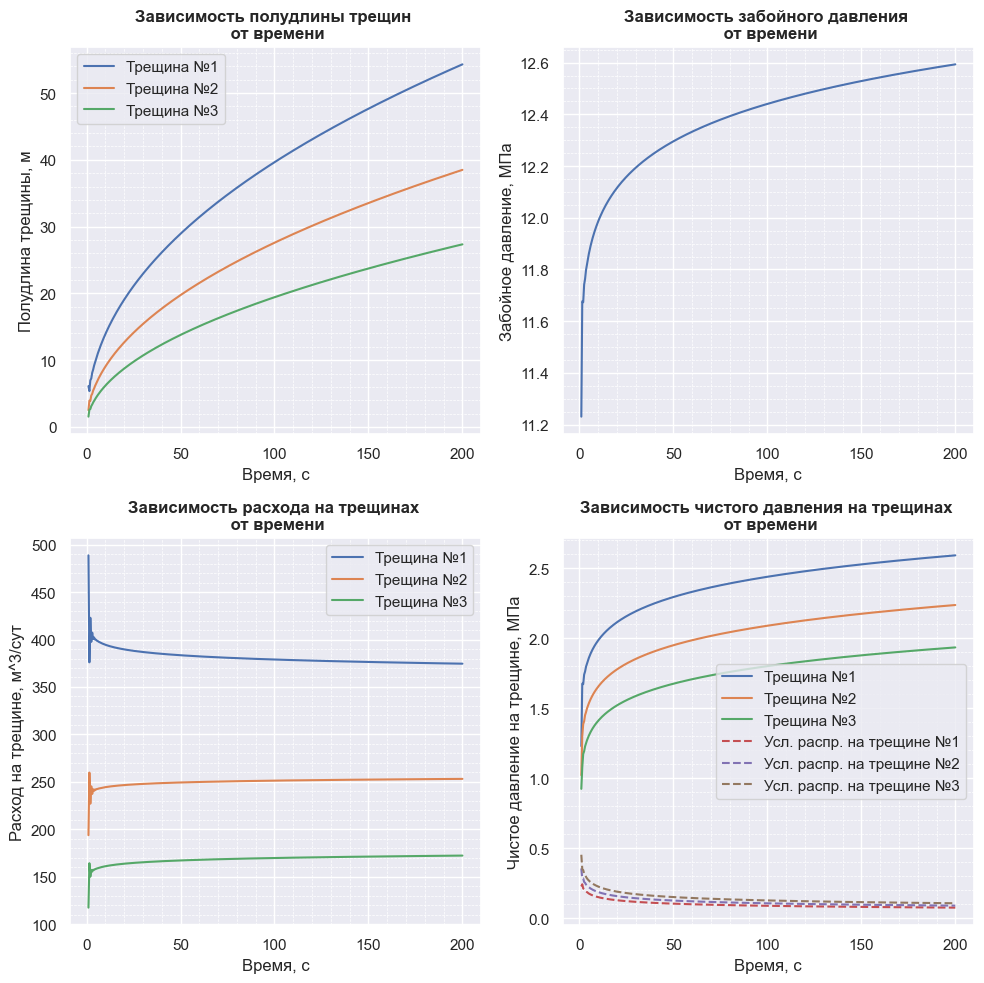

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))

axs[0,0].plot(times, x_frac_values, label=[f'Трещина №{i+1}' for i in range(fracs_count)])
axs[0,0].set_xlabel('Время, с')
axs[0,0].set_ylabel('Полудлина трещины, м')
axs[0,0].set_title('Зависимость полудлины трещин \n от времени', weight='bold')
axs[0,0].legend()
axs[0,0].minorticks_on()
axs[0,0].grid(which='minor', linestyle='--', linewidth=0.5)

axs[0,1].plot(times, np.array(p_0_values)/1e6)
axs[0,1].set_xlabel('Время, с')
axs[0,1].set_ylabel('Забойное давление, МПа')
axs[0,1].set_title('Зависимость забойного давления \n от времени', weight='bold')
axs[0,1].minorticks_on()
axs[0,1].grid(which='minor', linestyle='--', linewidth=0.5)

axs[1,0].plot(times, np.array(Q_values)*86400, label=[f'Трещина №{i+1}' for i in range(fracs_count)])
axs[1,0].set_xlabel('Время, с')
axs[1,0].set_ylabel('Расход на трещине, м^3/сут')
axs[1,0].set_title('Зависимость расхода на трещинах \n от времени', weight='bold')
axs[1,0].legend()
axs[1,0].minorticks_on()
axs[1,0].grid(which='minor', linestyle='--', linewidth=0.5)

axs[1,1].plot(times, np.array(p_net_values)/1e6, label=[f'Трещина №{i+1}' for i in range(fracs_count)])
axs[1,1].plot(times, np.array(p_net_prop_values)/1e6, linestyle='--',
              label=[f'Усл. распр. на трещине №{i+1}' for i in range(fracs_count)])
axs[1,1].set_xlabel('Время, с')
axs[1,1].set_ylabel('Чистое давление на трещине, МПа')
axs[1,1].set_title('Зависимость чистого давления на трещинах \n от времени', weight='bold')
axs[1,1].legend()
axs[1,1].minorticks_on()
axs[1,1].grid(which='minor', linestyle='--', linewidth=0.5)

fig.tight_layout()

# Заметки в черновике

In [7]:
for water_rate in np.array([400, 800, 1200, 1600]) / 86400:
    parameter_values[Q_0] = water_rate
    x_f_values = [i for i in range(1, 2000, 50)]
    p_0_values = []
    for x_f_value in x_f_values:
        for i in range(fracs_count):
            parameter_values[x_f[i]] = x_f_value
        solution_values = kirchhoff_solver(parameter_values)
        p_0_values.append(solution_values.get(p_0))
    plt.plot(x_f_values, np.array(p_0_values)/1e6, label=f'Q0 = {water_rate*86400} м^3/сут')
plt.xlabel('Полудлина трещин, м')
plt.ylabel('Забойное давление, МПа')
plt.title('Зависимость забойного давления от полудлины\n трещин при постоянном расходе на забое')
plt.minorticks_on()
plt.grid(which='minor', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

0.3270258903503418
0.33563685417175293
0.3434748649597168
0.34282994270324707
0.3546450138092041
0.42665910720825195
0.3277261257171631
0.35907816886901855
0.3299069404602051
0.30153608322143555
0.345778226852417
0.3245100975036621
0.3295772075653076
0.3878960609436035
0.38646411895751953
0.31719279289245605
0.32996296882629395
0.299771785736084
0.344897985458374
0.3092160224914551
0.33038783073425293
0.3207552433013916
0.4762282371520996
0.3519418239593506
0.3495140075683594
0.3083009719848633
0.33583903312683105
0.3115520477294922
0.3581581115722656
0.3145580291748047
0.4024472236633301
0.3693530559539795
0.3445460796356201
0.36233091354370117
0.347125768661499
0.33667588233947754
0.3982419967651367
0.31386232376098633
0.34383201599121094
0.3898129463195801
0.32738208770751953
0.30808186531066895
0.3231968879699707
0.29675793647766113
0.3278462886810303
0.2996211051940918
0.3252549171447754
0.30905890464782715
0.409268856048584
0.32883191108703613
0.3423480987548828
0.323080778121948

KeyboardInterrupt: 

KeyboardInterrupt: 

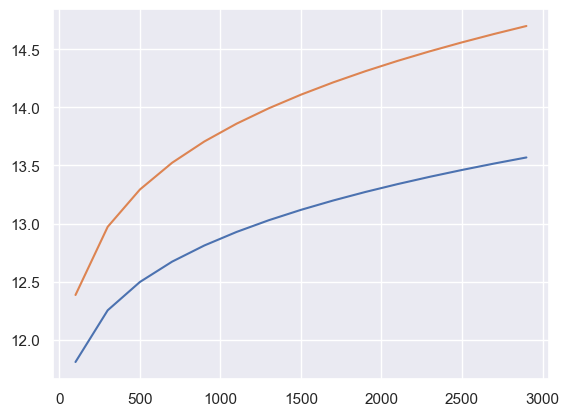

In [9]:
parameter_values[Q_0] = 800 / 86400
for i in range(fracs_count):
    parameter_values[x_f[i]] = 50 # полудлина трещины, м

for x_f_value in np.array([100, 400, 700, 1000]):
    for i in range(fracs_count):
        parameter_values[x_f[i]] = x_f_value

    water_rate_values = np.array(range(100, 3100, 200))
    p0_values = []

    for water_rate in water_rate_values / 86400:
        parameter_values[Q_0] = water_rate
        solution_values = kirchhoff_solver(parameter_values)
        p0_values.append(solution_values.get(p_0))

    plt.plot(water_rate_values, np.array(p0_values)/1e6, label=f'x_f = {x_f_value} м')
plt.xlabel('Суммарный расход на забое, м^3/сут')
plt.ylabel('Забойное давление, МПа')
plt.title('Зависимость забойного давления от расхода\n на забое (при постоянной полудлине трещин)')
plt.minorticks_on()
plt.grid(which='minor', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
#x_f = 

In [33]:
solution_values[symbols('Q1', real=True)]

0.0030868708806472017

In [10]:
x_f = koning_formula(Q_value, p_0_value, t)

TypeError: can't multiply sequence by non-int of type 'Symbol'

In [11]:
Q_value

[0.0030868708806472017, 0.0030863295115236247, 0.0030860588670884323]

In [15]:
p_0_value

11090545.832731105

In [17]:
x_f = koning_formula(Q_value[0], p_0_value, t)
x_f

array([0.0015434354403236*K*(k_e/(K*c_t*phi_e))**0.5/(pi**0.5*h1*k_e*(11090545.8327311 - p_e)),
       0.0015434354403236*K*(k_e/(K*c_t*phi_e))**0.5/(pi**0.5*h2*k_e*(11090545.8327311 - p_e)),
       0.0015434354403236*K*(k_e/(K*c_t*phi_e))**0.5/(pi**0.5*h3*k_e*(11090545.8327311 - p_e))],
      dtype=object)

In [12]:
parameter_values

{Q0: 0.009259259259259259,
 K: 0.001,
 n: 1,
 phi: 0.3,
 rho_s: 1000,
 x_f1: 1,
 E1: 10000000000.0,
 h1: 2,
 n_p1: 16,
 d_p1: 0.02,
 C_d1: 0.7,
 R1: 0.08,
 L1: 100,
 sigma_min1: 10000000.0,
 x_f2: 1,
 E2: 10000000000.0,
 h2: 2,
 n_p2: 16,
 d_p2: 0.02,
 C_d2: 0.7,
 R2: 0.08,
 L2: 100,
 sigma_min2: 10000000.0,
 x_f3: 1,
 E3: 10000000000.0,
 h3: 2,
 n_p3: 16,
 d_p3: 0.02,
 C_d3: 0.7,
 R3: 0.08,
 L3: 100,
 sigma_min3: 10000000.0}

In [17]:
solution_values = kirchhoff_solver(parameter_values)

In [18]:
p_prop = [N(i.subs({**parameter_values})) for i in sigma_min] + K_c / np.sqrt(np.pi * x_frac)

TypeError: can't multiply sequence by non-int of type 'float'